## Read input

In [1]:
%matplotlib inline

from operator import itemgetter
from matplotlib import pyplot as plt

from math import isnan
import numpy as np
import pandas
import pickle

from pyspark.mllib.clustering import KMeans, KMeansModel

K = 5

## K-means example 1

Use, for each station, and each of the 6 measurements, the average over all available years. Then use kmeans on the 6X365 dimensional vectors. You would probably want to run that on a large cluster 

In [2]:
parquetFile = sqlContext.read.parquet("/Weather")
rdd = parquetFile.rdd.cache()

In [3]:
station_measure = rdd.map(lambda r: (r['station'], r['measurement'])) \
                     .groupByKey() \
                     .mapValues(set) \
                     .cache()
print "Number of stations:", station_measure.count()

measures = ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
valid_stations = station_measure.filter(lambda p: all([t in p[1] for t in measures]))
print "Number of stations with all 6 measures:", valid_stations.count()

Number of stations: 47201
Number of stations with all 6 measures: 13265


In [5]:
def notnan(v):
    return 1.0 - 1.0 * np.isnan(v)


def nanadd((x, a), (y, b)):
    return np.nansum([x, y], axis=0), np.sum([a, b], axis=0)


### Compute for each valid station the aveage array for each measurement the average over all
### available 365D vectors.
avg_measure = rdd.filter(lambda r: r['station'] in stations and r['measurement'] in measures) \
                 .map(lambda r: ((r['station'], r['measurement']),
                                 np.array([r[str(i)] for i in range(1, 366)]))) \
                 .mapValues(lambda v: (v, 1 - np.isnan(v))) \
                 .reduceByKey(nanadd) \
                 .mapValues(lambda (a, b):
                            1.0 * np.nan_to_num(a) / (b + (b == 0))) \
                 .cache()

In [6]:
rec=avg_measure.first()
len(rec),rec[0],len(rec[1])

(2, (u'USC00185985', u'PRCP'), 365)

In [7]:
def construct_feature(mv):
    assert(len(mv) == 6)
    return np.concatenate(
        map(itemgetter(1), sorted(mv)))


bad_features = avg_measure.map(lambda ((station, measure), v): (station, (measure, v))) \
                          .groupByKey() \
                          .mapValues(construct_feature) \
                          .cache()
bad_features.count()

10911

In [8]:
T = 20
group = {}

data = bad_features.map(lambda p: p[1]).cache()
for i in range(T):
    # Run k-means
    clusters = KMeans.train(data, K)
    predicts = bad_features.mapValues(lambda v: clusters.predict(v)) \
                           .collectAsMap()
    for g, pred in predicts.items():
        group[g] = group.get(g, '') + ',' + str(pred)
    print "Iteration", i, "is finished."

Iteration 0 is finished.
Iteration 1 is finished.
Iteration 2 is finished.
Iteration 3 is finished.
Iteration 4 is finished.
Iteration 5 is finished.
Iteration 6 is finished.
Iteration 7 is finished.
Iteration 8 is finished.
Iteration 9 is finished.
Iteration 10 is finished.
Iteration 11 is finished.
Iteration 12 is finished.
Iteration 13 is finished.
Iteration 14 is finished.
Iteration 15 is finished.
Iteration 16 is finished.
Iteration 17 is finished.
Iteration 18 is finished.
Iteration 19 is finished.


9.2187600619037386

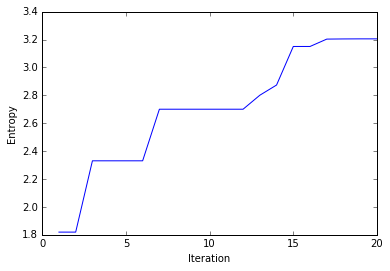

In [9]:
def compute_entropy(d):
    d = np.array(d)
    d = 1.0 * d / d.sum()
    return -np.sum(d * np.log2(d))

entropy = []
for i in range(T):
    count = {}
    for g, sig in group.items():
        _s = ','.join(sig[1:].split(',')[:(i + 1)])
        count[_s] = count.get(_s, 0) + 1
    entropy.append(compute_entropy(count.values()))

plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.plot(range(1, T + 1), entropy)
2**entropy[-1]

## K-means example 2

Use for each station, the 3X6 dimensional vector that Saurabh generated, and do Kmeans on that. That can probably run on a local spark.

In [4]:
proj = pickle.load(open('stations_projections.pickle', 'rb'))
print "Number of stations in the pickle file:", len(proj)

def construct_feature2(r):
    return np.concatenate(
        [r['TAVG_coeff'], r['TRANGE_coeff'], r['SNWD_coeff']])


_stations = valid_stations.map(lambda p: p[0]).collect()
_stations = set(_stations)

stations = set()
local = []
for idx, ser in proj.iterrows():
    if ser['station'] in _stations:
        stations.add(ser['station'])
        local.append((ser['station'],
                      construct_feature2(ser)))
print "Number of valid stations:", len(stations)

Number of stations in the pickle file: 12140
Number of valid stations: 10911


In [10]:
good_features = sc.parallelize(local) \
                  .cache()
_stations = set(
    good_features.map(lambda p: p[0]).collect())
good_features.count()

10911

In [11]:
T = 20
group2 = {}

data = good_features.map(lambda p: p[1]).cache()
for i in range(T):
    # Run k-means
    clusters = KMeans.train(data, K)
    predicts = good_features.mapValues(lambda v: clusters.predict(v)) \
                           .collectAsMap()
    for g, pred in predicts.items():
        group2[g] = group2.get(g, '') + ',' + str(pred)
    print "Iteration", i, "is finished."

Iteration 0 is finished.
Iteration 1 is finished.
Iteration 2 is finished.
Iteration 3 is finished.
Iteration 4 is finished.
Iteration 5 is finished.
Iteration 6 is finished.
Iteration 7 is finished.
Iteration 8 is finished.
Iteration 9 is finished.
Iteration 10 is finished.
Iteration 11 is finished.
Iteration 12 is finished.
Iteration 13 is finished.
Iteration 14 is finished.
Iteration 15 is finished.
Iteration 16 is finished.
Iteration 17 is finished.
Iteration 18 is finished.
Iteration 19 is finished.


4.9129119992653552

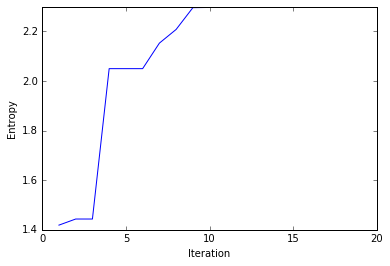

In [12]:
entropy2 = []
for i in range(T):
    count = {}
    for g, sig in group2.items():
        _s = ','.join(sig[1:].split(',')[:(i + 1)])
        count[_s] = count.get(_s, 0) + 1
    entropy2.append(compute_entropy(count.values()))

plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.plot(range(1, T + 1), entropy2)
2**entropy2[-1]

## Export stable clusters

In [13]:
stable = sorted(count.items(), 
                key=lambda p: p[1],
                reverse=True)[:K]
print stable
print ("Number of stations not in the top %d stable groups: %d" %
       (K, len(stations) - np.sum(map(itemgetter(1), stable))))

stable_groups = set([t[0] for t in stable])


[('2,0,3,0,2,4,3,2,0,2,2,4,0,3,2,3,0,1,0,1', 4519), ('0,2,0,4,1,1,0,0,2,1,1,0,4,0,0,0,4,2,4,0', 3839), ('2,0,3,3,4,3,3,4,0,2,0,3,3,3,2,2,3,4,3,4', 591), ('4,3,2,3,4,3,2,4,3,0,0,3,3,2,3,2,3,4,3,4', 584), ('0,2,0,0,2,4,0,2,2,1,2,4,0,0,0,3,0,1,0,1', 476)]
Number of stations not in the top 5 stable groups: 902


In [14]:
clusters = {t: [] for t in stable_groups}
for g, sig in group2.items():
    if sig[1:] in stable_groups:
        clusters[sig[1:]].append(g)

In [16]:
pickle.dump(clusters, open("stable-clusters.pickle", "wb"))